In [36]:
from google.colab import drive
drive.mount('/content/drive')
# df = pd.read_csv("/content/drive/MyDrive/WA_Fn-UseC_-HR-Employee-Attrition.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import (
    train_test_split, RepeatedKFold, GridSearchCV, cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Load & target‐encode
df = pd.read_csv("/content/drive/MyDrive/WA_Fn-UseC_-HR-Employee-Attrition.csv")
df["target"] = df["Attrition"].map({"Yes": 1, "No": 0})
df.drop(columns=["Attrition","EmployeeNumber","EmployeeCount","Over18","StandardHours"], inplace=True)

# 2) Split into train/test
X = df.drop(columns="target")
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 3) Identify categorical columns
cat_cols = X_train.select_dtypes(include=["object","category"]).columns.tolist()

# 4) For each categorical, compute its mode on TRAIN and build a “top‐category” dummy
modes = X_train[cat_cols].mode().iloc[0]
for col in cat_cols:
    top = modes[col]
    newcol = f"{col}_top"
    X_train[newcol] = (X_train[col] == top).astype(int)
    X_test[newcol]  = (X_test[col]  == top).astype(int)

# 5) Drop the original categoricals
X_train.drop(columns=cat_cols, inplace=True)
X_test .drop(columns=cat_cols, inplace=True)

# 6) Now all columns are numeric (original numerics + new dummies)
num_cols = X_train.columns.tolist()

# 7) Build a simple scaler pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler())
])

# 8) Fit/transform on TRAIN, transform on TEST
X_train_scaled = pipeline.fit_transform(X_train[num_cols])
X_test_scaled  = pipeline.transform(X_test[num_cols])

# 9) (Optional) wrap that into a reusable “preprocessor”
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", Pipeline([("scaler", StandardScaler())]), num_cols)
], remainder="drop")

# 10) Define your CV scheme
cv = KFold(n_splits=5, shuffle=True, random_state=10)


In [38]:
#OLS with CV
pipe_ols = Pipeline([
    ("pre", preprocessor),
    ("ols", LinearRegression())
])
mse_ols_cv = -cross_val_score(pipe_ols, X_train, y_train,
                              scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
r2_ols_cv  =  cross_val_score(pipe_ols, X_train, y_train,
                              scoring="r2", cv=cv, n_jobs=-1)
print(f"OLS CV MSE: {mse_ols_cv.mean():.4f} ± {mse_ols_cv.std():.4f}")
print(f"OLS CV R²:  {r2_ols_cv.mean():.4f} ± {r2_ols_cv.std():.4f}")
pipe_ols.fit(X_train, y_train)
y_pred_ols = pipe_ols.predict(X_test)

OLS CV MSE: 0.1122 ± 0.0067
OLS CV R²:  0.1666 ± 0.0564


In [39]:
reprocessor = pipe_ols.named_steps['pre']

#Transform the TRAIN data
X_train_proc = preprocessor.transform(X_train)

#Get feature names
try:
    feat_names = preprocessor.get_feature_names_out()
except AttributeError:
    feat_names = preprocessor.get_feature_names()

#Build DataFrame + intercept
X_train_df = pd.DataFrame(X_train_proc, columns=feat_names, index=X_train.index)
X_train_sm = sm.add_constant(X_train_df)

#Fit statsmodels OLS
ols_sm = sm.OLS(y_train, X_train_sm).fit()

#Print summary
print(ols_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     10.92
Date:                Wed, 07 May 2025   Prob (F-statistic):           1.25e-44
Time:                        04:11:13   Log-Likelihood:                -345.29
No. Observations:                1176   AIC:                             752.6
Df Residuals:                    1145   BIC:                             909.8
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [40]:
#Ridge with GridSearchCV
pipe_ridge = Pipeline([
    ("pre", preprocessor),
    ("ridge", Ridge())
])
param_ridge = {"ridge__alpha": np.logspace(-4, 4, 20)}
gs_ridge = GridSearchCV(pipe_ridge, param_ridge,
                        cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
gs_ridge.fit(X_train, y_train)
print(f"\nRidge best α: {gs_ridge.best_params_['ridge__alpha']:.4g}")
y_pred_ridge = gs_ridge.predict(X_test)



Ridge best α: 78.48


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la


RF best params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}


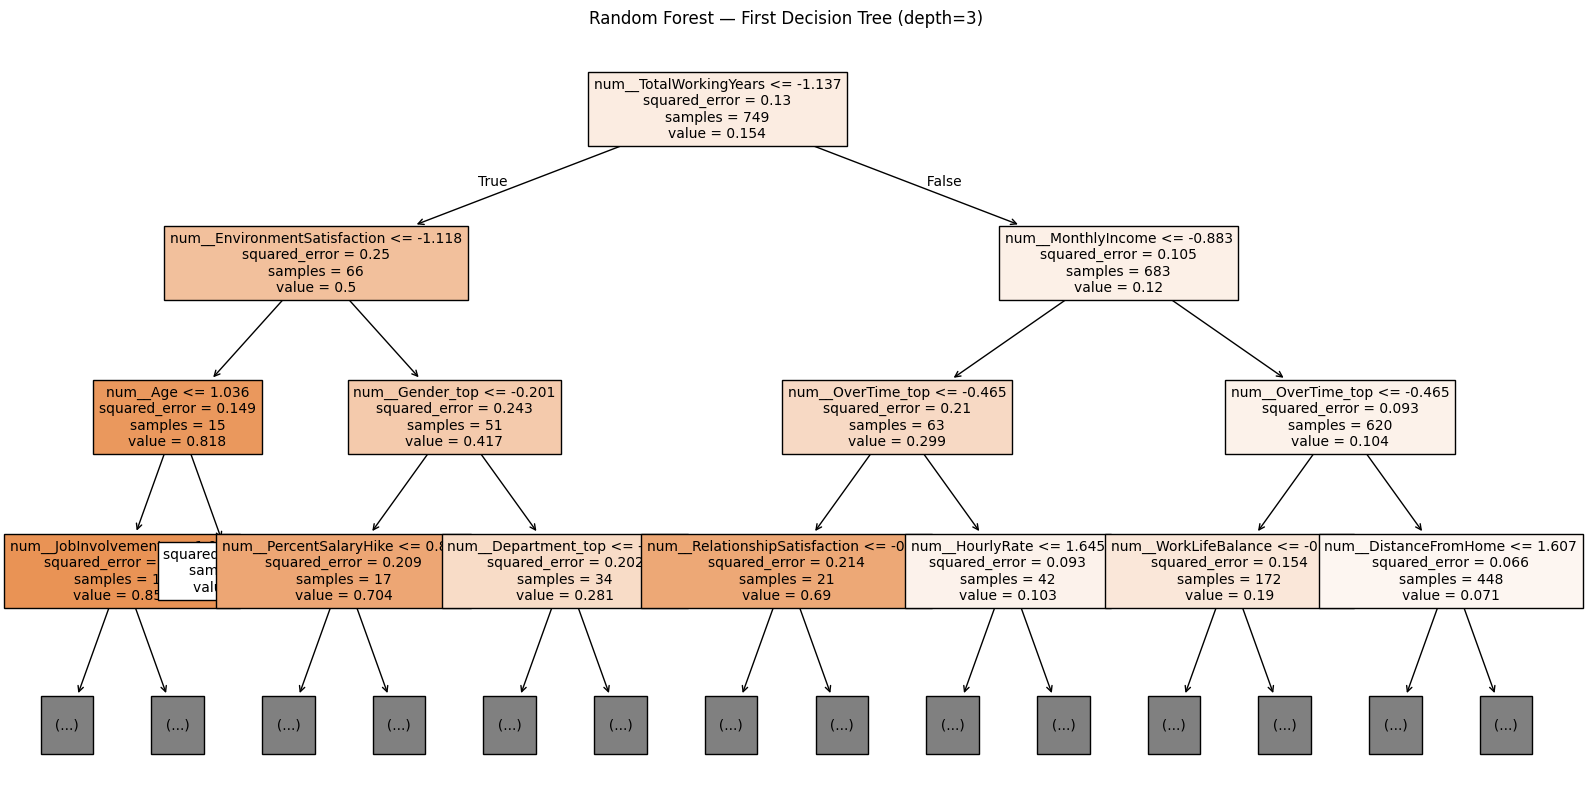

In [41]:
#Random Forest with GridSearchCV
pipe_rf = Pipeline([
    ("pre", preprocessor),
    ("rf",   RandomForestRegressor(random_state=42))
])
param_rf = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth":    [None, 5, 10],
    "rf__max_features": ["auto", "sqrt"]
}
gs_rf = GridSearchCV(pipe_rf, param_rf,
                     cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
gs_rf.fit(X_train, y_train)
print(f"\nRF best params: {gs_rf.best_params_}")
y_pred_rf = gs_rf.predict(X_test)

best_rf_pipeline = gs_rf.best_estimator_

#Locate your preprocessor and the RF regressor
preprocessor = best_rf_pipeline.named_steps['pre']
rf_model     = best_rf_pipeline.named_steps['rf']

#Recover feature names after preprocessing
try:
    feat_names = preprocessor.get_feature_names_out()
except AttributeError:
    feat_names = preprocessor.get_feature_names()

#Select the first tree from the trained forest
first_tree = rf_model.estimators_[0]

#Plot it (limit depth to 3 for clarity)
plt.figure(figsize=(20, 10))
tree.plot_tree(
    first_tree,
    feature_names=feat_names,
    filled=True,
    max_depth=3,
    fontsize=10
)
plt.title("Random Forest — First Decision Tree (depth=3)")
plt.show()

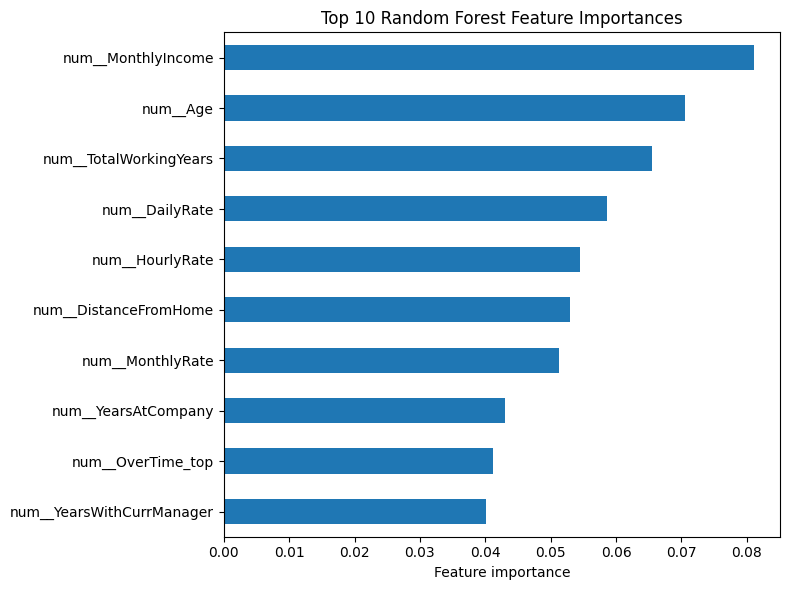

In [42]:
#Plot importances graph
importances = rf_model.feature_importances_
feat_imp   = pd.Series(importances, index=feat_names).sort_values(ascending=False)
top10      = feat_imp.head(10)

plt.figure(figsize=(8,6))
top10.plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("Feature importance")
plt.title("Top 10 Random Forest Feature Importances")
plt.tight_layout()
plt.show()

In [43]:
#Gradient Boosting with GridSearchCV
pipe_gbm = Pipeline([
    ("pre", preprocessor),
    ("gbm",  GradientBoostingRegressor(random_state=42))
])
param_gbm = {
    "gbm__n_estimators":  [100, 200],
    "gbm__learning_rate": [0.05, 0.1],
    "gbm__max_depth":     [3, 5]
}
gs_gbm = GridSearchCV(pipe_gbm, param_gbm,
                      cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
gs_gbm.fit(X_train, y_train)
print(f"\nGBM best params: {gs_gbm.best_params_}")
y_pred_gbm = gs_gbm.predict(X_test)


GBM best params: {'gbm__learning_rate': 0.05, 'gbm__max_depth': 3, 'gbm__n_estimators': 100}


In [44]:
#Evaluate on the test set
models = {
    "OLS":   y_pred_ols,
    "Ridge": y_pred_ridge,
    "RF":    y_pred_rf,
    "GBM":   y_pred_gbm
}

print("\nTest-set performance:")
print(f"{'Model':<6} {'MSE':>8} {'MAE':>8} {'R²':>8}")
for name, y_pred in models.items():
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    print(f"{name:<6} {mse:8.4f} {mae:8.4f} {r2:8.4f}")

best_mse = min(models, key=lambda m: mean_squared_error(y_test, models[m]))
best_r2  = max(models, key=lambda m: r2_score(y_test,       models[m]))
print(f"\nBest by MSE → {best_mse}")
print(f"Best by R²  → {best_r2}")


Test-set performance:
Model       MSE      MAE       R²
OLS      0.1118   0.2468   0.1676
Ridge    0.1113   0.2445   0.1715
RF       0.1167   0.2423   0.1308
GBM      0.1136   0.2261   0.1539

Best by MSE → Ridge
Best by R²  → Ridge


In [45]:
#Logistic Regression
from sklearn.metrics import accuracy_score
clf_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(solver="liblinear", random_state=42))
])

clf_pipe.fit(X_train, y_train)
y_pred = clf_pipe.predict(X_test)

acc   = accuracy_score(y_test, y_pred)
error = 1 - acc

print(f"Accuracy       : {acc:.4f}")
print(f"Classification error rate: {error:.4f}")

Accuracy       : 0.8810
Classification error rate: 0.1190
